# GRU Test on Single Time Series

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
sns.set()
import gc



In [2]:
plt.style.use("seaborn")
sns.set(font_scale=1)

seed = 777
random.seed(seed)

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Set up Training data preprocess

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
train_df = pd.read_csv('ashrae-energy-prediction/train.csv', parse_dates = ['timestamp'])

In [6]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Prepare Single Time Series for LSTM

In [7]:
train_df = train_df.loc[train_df['building_id']==1200]
train_df = train_df.loc[train_df['meter']== 2]

In [8]:
train_df

,building_id,meter,timestamp,meter_reading
1730,1200,2,2016-01-01 00:00:00,6838.47
4026,1200,2,2016-01-01 01:00:00,6838.47
6322,1200,2,2016-01-01 02:00:00,6505.78
8621,1200,2,2016-01-01 03:00:00,6355.78
10916,1200,2,2016-01-01 04:00:00,6830.78
...,...,...,...,...
20206057,1200,2,2016-12-31 19:00:00,6021.16
20208420,1200,2,2016-12-31 20:00:00,5567.32
20210785,1200,2,2016-12-31 21:00:00,4638.47
20213152,1200,2,2016-12-31 22:00:00,4075.01


In [9]:
train_df.index = train_df.timestamp
del train_df['timestamp']

In [10]:
train_df.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8784, freq=None)

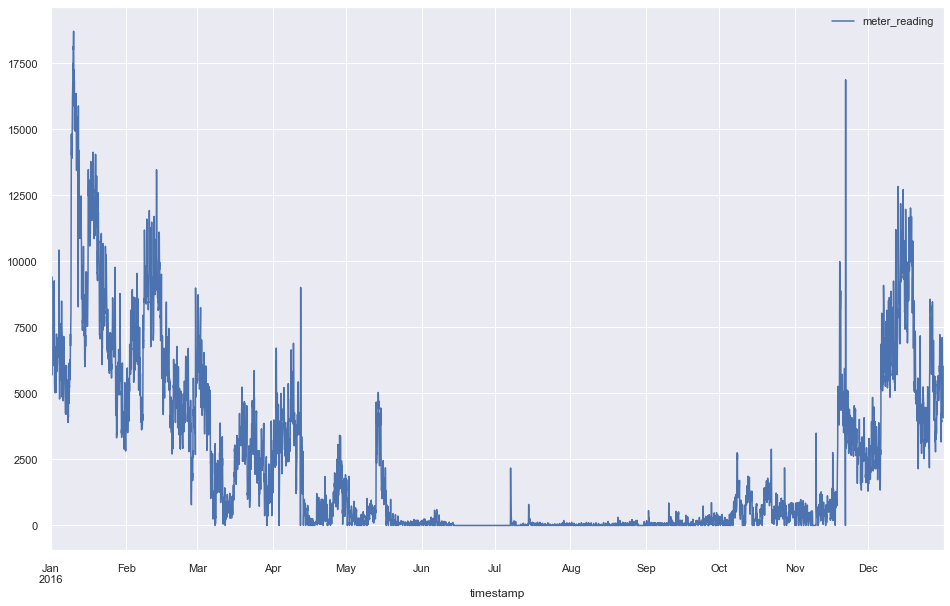

In [11]:
train_df[['meter_reading']].plot(figsize=(16,10))
plt.show()

In [12]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [13]:
#train_df['meter_reading'] = np.log1p(train_df['meter_reading'])

In [14]:
sc = MinMaxScaler()
# training_data = sc.fit_transform(train_df['pct_diff'].dropna().values.reshape(-1, 1))
training_data = sc.fit_transform(train_df['meter_reading'].values.reshape(-1, 1))

In [15]:
training_data

array([[0.36558019],
       [0.36558019],
       [0.3477948 ],
       ...,
       [0.24796961],
       [0.21784741],
       [0.24067027]])

In [16]:
seq_length = 24
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [17]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        
#         self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
#         h_out = self.dropout(h_out)
        
        out = self.fc(h_out)
        
        return out

In [18]:
num_epochs = 1000
learning_rate = 0.1
momentum = 0.9

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

gru = GRU(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(gru.parameters(), lr=learning_rate, momentum=momentum)

# Train the model
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.16162
Epoch: 100, loss: 0.00078
Epoch: 200, loss: 0.00071
Epoch: 300, loss: 0.00069
Epoch: 400, loss: 0.00067
Epoch: 500, loss: 0.00065
Epoch: 600, loss: 0.00064
Epoch: 700, loss: 0.00063
Epoch: 800, loss: 0.00061
Epoch: 900, loss: 0.00060


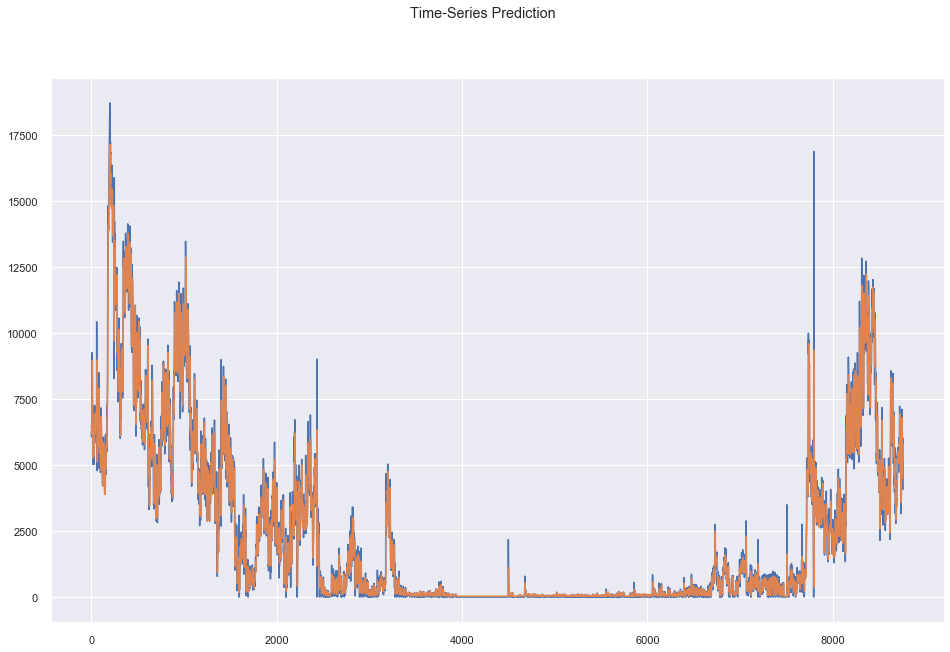

In [19]:
gru.eval()
train_predict = gru(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(16,10))
#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [70]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error

In [72]:
print(mape(data_predict, dataY_plot))
print(r2_score(data_predict, dataY_plot))
print(mean_absolute_error(data_predict, dataY_plot))
print(np.sqrt(mean_squared_error(data_predict, dataY_plot)))
print(max_error(data_predict, dataY_plot))

54.41749691963196
0.9777550974886419
234.45282
480.73355
16924.14
